In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw2.ipynb")

## Homework #2

*Please edit the cell below to add your full name (first and last) and the full names of any group members that you collaborated with on this assignment.* 

Name: Runze Li  
Group Members: None   
***

In [2]:
# Set random seed and ensure plots are displayed in the notebook
import numpy as np
rnd_seed = 42
np.random.seed(rnd_seed)
%matplotlib inline

<!-- BEGIN QUESTION -->

**Important Note**: *All solutions to the problems below must use the approaches taught so far in the course for answering the questions. There are other approaches for solving these problems that do not require the use of Bayesian approaches, PyMC, quadratic approximation, etc. However, we will soon encounter problems where those tools lack the functionality that is needed to solve the problems. It will be to your benefit to practice using the approach shown in lecture and found in the textbook to begin practicing for what is to come later. In addition, you will not receive full credit on your answers if you do not use the techniques being taught in the course.*

**Question 1 (20 points)**. Construct a linear regression of weight as predicted by height, using the adults (age 18 or greater) from the Howell1 (`Data/Howell1.csv`) dataset. **Be sure to use a quadratic approximation of the posterior distribution as demonstrated in lecture.**

**Note** : _Complete this exercise without using the `pymc.sample_posterior_predictive` function._

_Type your answer here, replacing this text._

In [3]:
# Write code here
from scipy import stats
import numpy as np
from matplotlib import animation, pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
from quap import quap

import arviz as az

# Load the data
data = pd.read_csv('Data/Howell1.csv', sep=";", header=0)
# print(data)

d2 = data[data.age >= 18]
H = d2.height
W = d2.weight
# print(d2)
# print(H)

In [4]:
weight_mean = d2['weight'].mean()
weight_std = d2['weight'].std()
height_mean = d2['height'].mean()

with pm.Model() as m_HW:
    a = pm.Normal('a', weight_mean, weight_std)
    b = pm.Lognormal('b', 0, 1)
    sigma = pm.Exponential('sigma', 1)
    mu = a + b*(d2.height-height_mean)
    weight = pm.Normal('weight', mu, sigma, observed=d2.weight)
    idata_HW, posterior_HW = quap([a, b, sigma])

az.summary(idata_HW, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,44.992,0.225,44.565,45.407
b,0.629,0.046,0.541,0.713
sigma,4.205,0.037,4.137,4.276


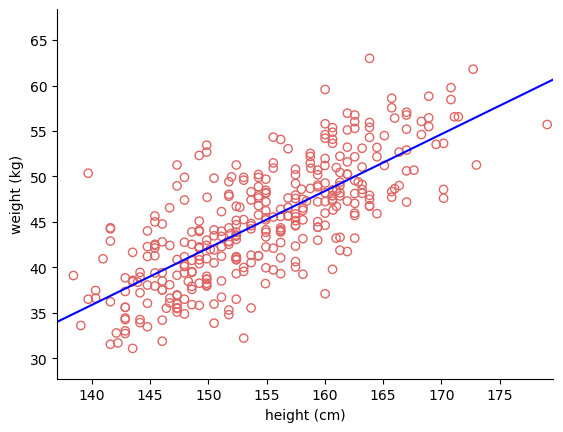

In [5]:
_ = plt.scatter(H, W, facecolors='none', edgecolors="#e06666")
_ = plt.xlabel("height (cm)")
_ = plt.ylabel("weight (kg)")
_ = sns.despine()

height_seq = np.arange(130, 190)
idata_thinned = az.extract(idata_HW, num_samples=1000)

mu_pred = np.zeros((len(height_seq), idata_thinned.sizes["sample"]))
a_values = idata_thinned.a.values
b_values = idata_thinned.b.values

for i, h in enumerate(height_seq):
    mu_pred[i] = a_values + b_values * (h - H.mean())

mu_mean = mu_pred.mean(1)

_ = plt.plot(height_seq, mu_mean, color='b')
plt.xlim(H.min()+0.5, H.max()+0.5);

Consider the heights listed below which were recorded in the community census, but weights were not recorded for these individuals. Provide predicted weights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions **of outcome weights. This requires simulating weights from the model's data distribution/likelihood using samples from the posterior distribution. Report the average weight prediction for each height in the table.** 

The table can be edited by double-clicking in the cell containing the table.

In [6]:
heights = [140, 160, 175]
weights_pred = []

idata_thinned = az.extract(idata_HW, num_samples=1000)
a_values = idata_thinned.a.values
b_values = idata_thinned.b.values

for height in heights:
    mu_sample = a_values + b_values*(height-height_mean)
    weight_sample = np.mean(mu_sample)
    lower_bound, upper_bound = np.percentile(mu_sample, [5.5, 94.5])
    weights_pred.append((weight_sample, lower_bound, upper_bound))

for i in range(len(heights)):
    print("height:", heights[i], "; weight_pred:", round(weights_pred[i][0], 2), "; 89 interval: [", round(weights_pred[i][1], 2), round(weights_pred[i][2], 2), "]")

height: 140 ; weight_pred: 35.83 ; 89 interval: [ 34.73 36.97 ]
height: 160 ; weight_pred: 48.38 ; 89 interval: [ 47.85 48.94 ]
height: 175 ; weight_pred: 57.8 ; 89 interval: [ 56.29 59.28 ]


|Individual|height|predicted weight|89% interval|
|:---|:---|:---|:---|
| 1 | 140 | 35.83 | (34.73, 36.97) |
| 2 | 160 | 48.38 | (47.85, 48.94)|
| 3 | 175 | 57.8 | (56.29, 59.28)| 

|Individual|height|predicted weight|89% interval|
|:---|:---|:---|:---|
| 1 | 140 |  | ( , ) |
| 2 | 160 |  | ( , )|
| 3 | 175 |  | ( , )| 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2 (20 points)**. From the Howell1 dataset, consider only the people younger than 13 years old.

**Using a quadratic approximation of the posterior distribution**, estimate the causal association between age and weight. Assume that age influences weight through two paths.
- First, age influences height, and height influences weight.
- Second, age directly influences weight through age-related changes in muscle growth and body proportions.

All of this implies the following causal model (represented as a DAG):

<!--- ![causal diagram](dag.png) --->  

Think carefully before reusing any priors from the similar problem encountered in lecture. Be sure to **justify any prior choices that you make for intercept and slope parameters** in your model.

_Type your answer here, replacing this text._

In [7]:
df = pd.read_csv("Data/Howell1.csv", sep=';', header=0)
df2 = df[df.age < 13]
age = df2.age
print(df2[df.age==0].mean())

height    63.326818
weight     6.754913
age        0.000000
male       0.363636
dtype: float64


/tmp/ipykernel_1841/1098457769.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df2[df.age==0].mean())


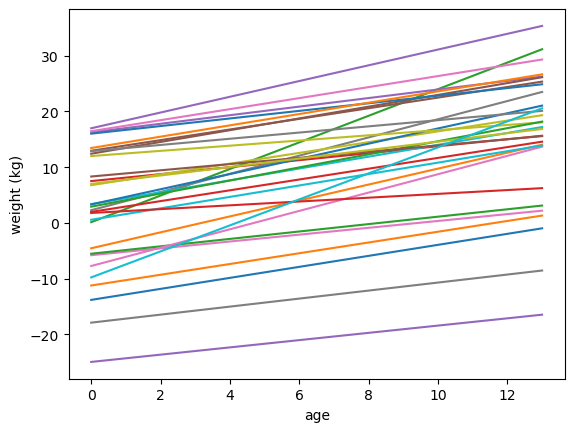

In [8]:
n = 30
alpha = stats.norm.rvs(6,10, size=n)
beta = stats.lognorm.rvs(s=0.5, loc=0, size=n)

age_seq = np.linspace(0, 13, 100)

for i in range(n):
    plt.plot(age_seq, alpha[i]+beta[i]*age_seq)

plt.xlabel("age")
plt.ylabel("weight (kg)")
plt.show()

We find that the average weight of 0-year-old kid is about 6 kg, so we set the prior distribution:

- alpha = Normal(6, 10)
- beta = LogNormal(0, 0.5)
- sigma = Uniform(0, 10)
- mu = alpha+beta*age\_seq
- W = Normal(mu, sigma)

Now use a linear regression to estimate the **total (not just direct)** causal effect of **each year of growth** on weight.

**Define your linear model such that the model intercept can be interpreted as the expected weight at birth.**

**Be sure to carefully consider the priors.** Provide justification for the distributions used for the priors by using a prior predictive simulation to assess the implications of your prior choice. 

**Note** : _For this excercise, perform the prior predictive simulation manually (i.e. do not use `pymc.sample_prior_predictive`)._

_Type your answer here, replacing this text._

In [9]:
with pm.Model() as m_AW:
    a = pm.Normal('a', 6, 10)
    b = pm.Lognormal('b', 0, 0.5)
    mu = pm.Deterministic("mu", a + b * df2.age)
    sigma = pm.Uniform("sigma", 0, 10)
    weight = pm.Normal("weight", mu, sigma, observed=df2.weight)
    idata, posterior = quap([a, b, sigma], n_samples=1000)

az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,7.482,0.380,6.789,8.202
b,1.336,0.043,1.256,1.415
sigma,2.527,0.077,2.398,2.686


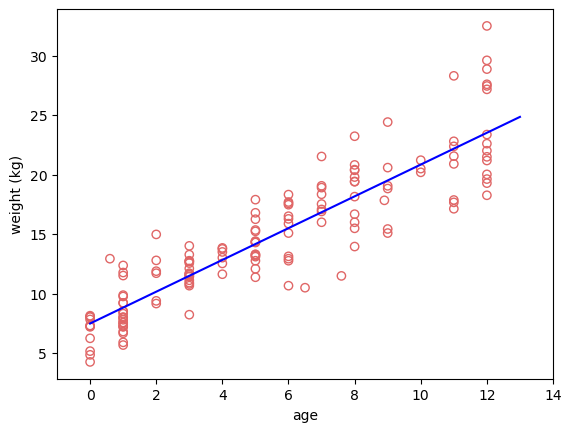

In [10]:
age_seq = np.linspace(0, 13, 100)
idata_thinned = az.extract(idata, num_samples=1000)

mu_pred = np.zeros((len(age_seq), idata_thinned.sizes["sample"]))
a_values = idata_thinned.a.values
b_values = idata_thinned.b.values

for i, age in enumerate(age_seq):
    mu_pred[i] = a_values + b_values * age

mu_mean = mu_pred.mean(1)

plt.scatter(df2.age, df2.weight, facecolors='none', edgecolors="#e06666")
plt.plot(age_seq, mu_mean, color='b')
plt.xlabel("age")
plt.ylabel("weight (kg)")
plt.xlim(-1, 14);

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 3 (10 points)**. Now suppose the causal association between age and weight might be different based on reported gender for the same age group as in Question 2. 

Use a single linear regression, with a categorical variable for gender, to **estimate the total causal effect** of age on weight separately for boys and girls.

Be sure to **use index-based encoding of the categories** and **approximate the posterior distribution using a quadratic approximation** as demonstrated in lecture.

_Type your answer here, replacing this text._

In [13]:
# Write code here

df = pd.read_csv("Data/Howell1.csv", sep=';', header=0)
df2 = df[df.age < 13]
gen = df2.male

with pm.Model() as m_GAW:
    a = pm.Normal('a', 6, 10, shape=2)
    b = pm.Lognormal('b', 0, 0.5, shape=2)
    mu = pm.Deterministic("mu", a[gen] + b[gen] * df2.age)
    sigma = pm.Uniform("sigma", 0, 10)
    
    weight = pm.Normal("weight", mu, sigma, observed=df2.weight)
    
    m_GAW_idata, _ = quap([a, b, sigma])

az.summary(m_GAW_idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a[0],7.109,0.477,6.196,7.992
a[1],7.941,0.511,6.969,8.896
b[0],1.281,0.057,1.175,1.387
b[1],1.379,0.055,1.281,1.488
sigma,2.423,0.077,2.282,2.571


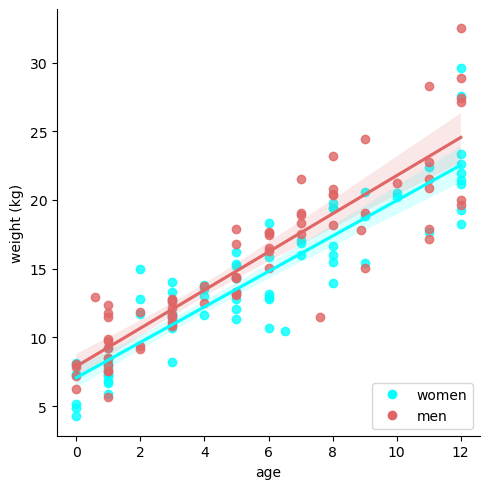

In [14]:
from matplotlib.lines import Line2D

ax = sns.lmplot(
    data=df2, x="age", y="weight", hue="male", palette=["cyan", "#e06666"], legend=False
)

custom = [Line2D([], [], marker='o', color="cyan", linestyle='None'),
          Line2D([], [], marker='o', color="#e06666", linestyle='None')]

_ = plt.legend(custom, ['women', 'men'], loc='lower right')
_ = plt.xlabel("age")
_ = plt.ylabel("weight (kg)")
_ = sns.despine()

How do girls and boys differ according to your model results?
- Provide one or more posterior contrast plots to support your answer.

_Type your answer here, replacing this text._

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/

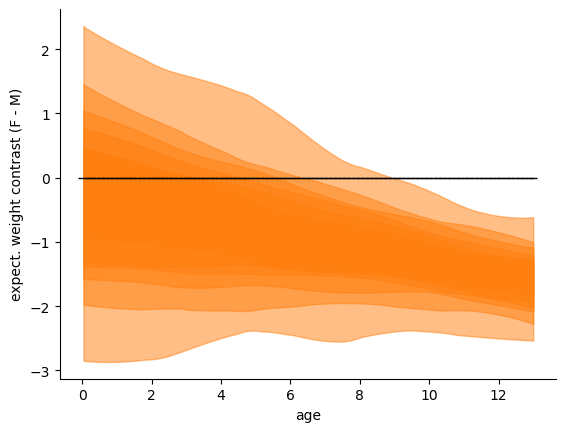

In [15]:
age_seq = np.linspace(0, 13, 100)

data_thin = az.extract(m_GAW_idata, num_samples = 1000)
mu_pred_W = np.empty((len(age_seq), data_thin.sizes["sample"]))
mu_pred_M = np.empty((len(age_seq), data_thin.sizes["sample"]))

for i, age in enumerate(age_seq):
    mu_pred_W[i] = data_thin.a.values[0] + data_thin.b.values[0] * age
    mu_pred_M[i] = data_thin.a.values[1] + data_thin.b.values[1] * age
    
mu_pred_contrast = mu_pred_W - mu_pred_M
  
for p in [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]:
    _ = az.plot_hdi(age_seq, mu_pred_contrast.T, hdi_prob=p)
 
_ = plt.plot(age_seq, [0] * len(age_seq), "_", color='k')
_ = plt.xlabel("age")
_ = plt.ylabel("expect. weight contrast (F - M)")
_ = sns.despine()

We can see that the hdi distribution deviates from 0 in the comparison chart, which indicates that there is a relatively large difference in weight between boys and girls. Specifically, boys weigh more than girls at the same age.

In [16]:
grader.check("q3")

q3 results: All test cases passed!

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [17]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q3 results: All test cases passed!
